<a href="https://colab.research.google.com/github/ritikdhame/Reward-Model-for-Evaluating-Machine-Translations/blob/main/Reward_models_in_large_language_models_(LLMs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Getting Dependencies**

In [ ]:
!python -m venv reward_env
!source reward_env/bin/activate  # On Windows: reward_env\Scripts\activate
!pip install torch transformers datasets pandas numpy matplotlib seaborn

Error: Command '['/content/reward_env/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: line 1: reward_env/bin/activate: No such file or directory
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.5 MB/s eta 0:00:0

**Step 2: Prepare the Dataset**

We’ll use a small, publicly available dataset of movie subtitles. For this example, you can use a dataset like the OpenSubtitles dataset (available via the datasets library) or manually curate a small set of English-Spanish subtitle pairs. Here’s how to load and preprocess:

In [ ]:
import pandas as pd

# Assuming a small sample dataset is uploaded to Colab (e.g., via Files upload)
# Upload a file named 'sample_en_es.csv' with columns 'en' and 'es' to Colab's file system
df = pd.read_csv("/content/sample_en_es.csv")

# Filter out any empty rows and limit to 1000 samples
df = df[(df["en"] != "") & (df["es"] != "")].head(1000)

# Store the dataset as a CSV file in Colab
df.to_csv("/content/subtitles_en_es.csv", index=False)

# Verify the data
print(f"Dataset saved with {len(df)} samples. First few rows:")
print(df.head())

Dataset saved with 10 samples. First few rows:
              en                         es
0    Hello world                 Hola mundo
1   Good morning                Buenos días
2      Thank you                    Gracias
3  I love movies  Me encantan las películas
4  See you later                Hasta luego


**Step 3: Generate Translation Candidates**
We'll use the MarianMT model to generate multiple Spanish translation candidates for each English sentence in the dataset.

In [ ]:
import pandas as pd
from transformers import MarianTokenizer, MarianMTModel

# Load the dataset
df = pd.read_csv("/content/subtitles_en_es.csv")

# Load the MarianMT model and tokenizer for English-to-Spanish
model_name = "Helsinki-NLP/opus-mt-en-es"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Function to generate multiple translations by tweaking the decoding
def generate_translations(text, num_candidates=3):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    translations = []
    for i in range(num_candidates):
        # Use different beam search parameters to get varied outputs
        outputs = model.generate(
            **inputs,
            num_beams=5 + i,  # Vary beam width
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            early_stopping=True
        )
        translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        translations.append(translated_text)
    return translations

# Generate translation candidates for the dataset
df["candidates"] = df["en"].apply(lambda x: generate_translations(x))
df.to_csv("/content/subtitles_with_candidates.csv", index=False)

# Verify the data
print("Translation candidates generated. First few rows:")
print(df.head())

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

Translation candidates generated. First few rows:
              en                         es  \
0    Hello world                 Hola mundo   
1   Good morning                Buenos días   
2      Thank you                    Gracias   
3  I love movies  Me encantan las películas   
4  See you later                Hasta luego   

                                          candidates  
0               [Hola mundo, Hola mundo, Hola mundo]  
1         [Buenos días., Buenos días., Buenos días.]  
2                     [Gracias., Gracias., Gracias.]  
3  [Me encantan las películas., Me encantan las p...  
4         [Hasta luego., Hasta luego., Hasta luego.]  


**Step 4: Simulate Human Preferences**
We'll simulate human preferences by comparing the generated translations to the reference translations using BLEU scores as a proxy for quality.

In [ ]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu

# Load the dataset with candidates
df = pd.read_csv("/content/subtitles_with_candidates.csv")

# Compute BLEU scores for each candidate against the reference
def compute_bleu_scores(row):
    reference = row["es"].split()
    scores = []
    for candidate in eval(row["candidates"]):  # Convert string representation of list back to list
        candidate_tokens = candidate.split()
        score = sentence_bleu([reference], candidate_tokens, weights=(0.5, 0.5, 0, 0))  # Bigram BLEU
        scores.append(score)
    return scores

df["bleu_scores"] = df.apply(compute_bleu_scores, axis=1)

# Simulate preferences: the candidate with the highest BLEU score is "preferred"
df["preferred_idx"] = df["bleu_scores"].apply(lambda x: x.index(max(x)))
df.to_csv("/content/subtitles_with_preferences.csv", index=False)

# Verify the data
print("Preferences simulated. First few rows:")
print(df.head())

Preferences simulated. First few rows:
              en                         es  \
0    Hello world                 Hola mundo   
1   Good morning                Buenos días   
2      Thank you                    Gracias   
3  I love movies  Me encantan las películas   
4  See you later                Hasta luego   

                                          candidates  \
0         ['Hola mundo', 'Hola mundo', 'Hola mundo']   
1   ['Buenos días.', 'Buenos días.', 'Buenos días.']   
2               ['Gracias.', 'Gracias.', 'Gracias.']   
3  ['Me encantan las películas.', 'Me encantan la...   
4   ['Hasta luego.', 'Hasta luego.', 'Hasta luego.']   

                                         bleu_scores  preferred_idx  
0                                    [1.0, 1.0, 1.0]              0  
1  [1.0547686614863434e-154, 1.0547686614863434e-...              0  
2                                          [0, 0, 0]              0  
3  [0.7071067811865475, 0.7071067811865475, 0.707...         

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

**Step 5: Train the Reward Model**
We'll train a BERT-based reward model to predict a scalar reward score for each translation candidate, learning to assign higher scores to the "preferred" translations.

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Load the dataset with preferences
df = pd.read_csv("/content/subtitles_with_preferences.csv")

# Load BERT tokenizer and model
reward_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
reward_model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=1)

# Prepare the dataset for training the reward model
class RewardDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df) * 3  # Each row has 3 candidates

    def __getitem__(self, idx):
        row_idx = idx // 3
        candidate_idx = idx % 3
        row = self.df.iloc[row_idx]
        candidate = eval(row["candidates"])[candidate_idx]  # Convert string representation back to list
        label = 1.0 if candidate_idx == row["preferred_idx"] else 0.0  # Binary reward

        encoding = reward_tokenizer(
            candidate,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding["labels"] = torch.tensor(label, dtype=torch.float)
        return encoding

# Split into train and test
train_df = df.iloc[:8]  # Small dataset (10 rows), so 80% train
test_df = df.iloc[8:]
train_dataset = RewardDataset(train_df)
test_dataset = RewardDataset(test_df)

# Training arguments (updated parameter name)
training_args = TrainingArguments(
    output_dir="/content/reward_model",
    num_train_epochs=3,
    per_device_train_batch_size=4,  # Smaller batch size for small dataset
    per_device_eval_batch_size=4,
    eval_strategy="epoch",  # Changed from evaluation_strategy to eval_strategy
    save_strategy="epoch",
    logging_dir="/content/logs",
    logging_steps=10,
)

# Initialize trainer
trainer = Trainer(
    model=reward_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the reward model
trainer.train()

# Save the model
reward_model.save_pretrained("/content/reward_model_final")
reward_tokenizer.save_pretrained("/content/reward_model_final")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: phirkidhar (phirkidhar-phirkidhar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.223677
2,0.465000,0.236408
3,0.465000,0.228364


('/content/reward_model_final/tokenizer_config.json',
 '/content/reward_model_final/special_tokens_map.json',
 '/content/reward_model_final/vocab.txt',
 '/content/reward_model_final/added_tokens.json')

**Step 6: Evaluate the Reward Model**
This code will load the trained reward model, score the translation candidates, calculate the accuracy of ranking preferred translations, and create a visualization of the reward score distribution.

<ipython-input-15-eb1336a5d11a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["reward_scores"] = test_df["candidates"].apply(score_translations)
<ipython-input-15-eb1336a5d11a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["predicted_best_idx"] = test_df["reward_scores"].apply(lambda x: x.index(max(x)))


Reward Model Accuracy: 1.00


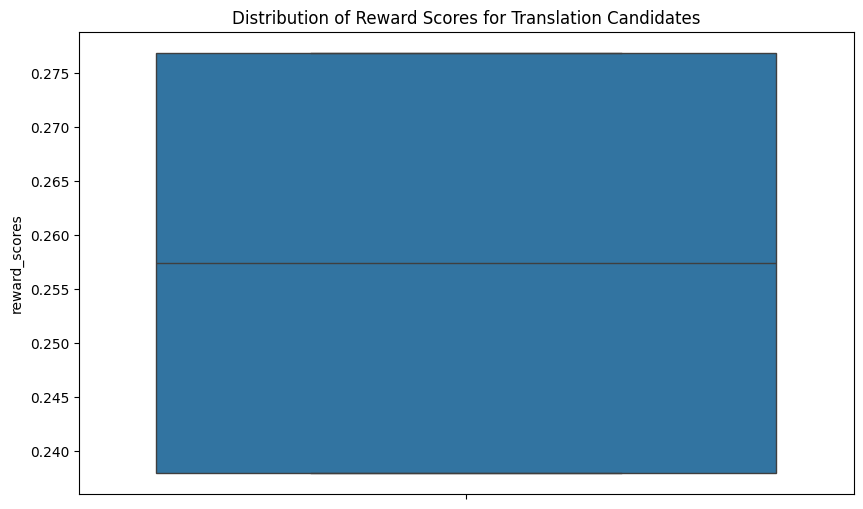

In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification

# Load the dataset with preferences
df = pd.read_csv("/content/subtitles_with_preferences.csv")

# Load the trained reward model and tokenizer
reward_tokenizer = BertTokenizer.from_pretrained("/content/reward_model_final")
reward_model = BertForSequenceClassification.from_pretrained("/content/reward_model_final")

# Function to score translations using the reward model
def score_translations(candidates):
    scores = []
    for candidate in eval(candidates):  # Convert string representation back to list
        inputs = reward_tokenizer(candidate, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = reward_model(**inputs).logits
        scores.append(outputs.item())
    return scores

# Score the test set
test_df = df.iloc[8:]  # Use the same test split as before (last 2 rows of 10)
test_df["reward_scores"] = test_df["candidates"].apply(score_translations)

# Check if the highest reward score matches the preferred translation
test_df["predicted_best_idx"] = test_df["reward_scores"].apply(lambda x: x.index(max(x)))
accuracy = (test_df["predicted_best_idx"] == test_df["preferred_idx"]).mean()
print(f"Reward Model Accuracy: {accuracy:.2f}")

# Visualize the results
plt.figure(figsize=(10, 6))
sns.boxplot(data=test_df["reward_scores"].explode())
plt.title("Distribution of Reward Scores for Translation Candidates")
plt.savefig("/content/reward_scores_distribution.png")
plt.show()